# Example: TimeSeries Forecasting

https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

Using SimpleRNN for timeseries forecasting, on the Sunspots dataset. 

This is a simple timeseries dataset containing, for each month, the mean number of sunspots happended in that month. Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. https://en.wikipedia.org/wiki/Sunspot

## DATASET

### Download

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
df = pd.read_csv(sunspots_url, usecols=[1], engine='python')
data = np.array(df.values.astype('float32')) # To float

### Brief analyisis
Timeseries dataset containing $2820$ values. Basically, we have $2820$ months, and for each month we have the mean number of sunspots happened in that month.

In [ ]:
data.shape

(2820, 1)

In [ ]:
# Number of sunspots happened in the first month
data[0][0]

58.0

### Normalization
We normalize each value into the range $[0,1]$. MinMax scaling.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data = MinMaxScaler(feature_range=(0, 1)).fit_transform(data).flatten()

### Train-Test splitting
We take the $80%$ of samples as training data, the remaining as test data.

In [ ]:
n_train_samples = int(0.8*len(data))
train_data = data[:n_train_samples]
test_data = data[n_train_samples:]

## RNN 
Let's now define the RNN.

### Input
The kind of input values we want to process are simply numbers. Each input element $X_t$ is a single value, it's a single number (i.e. monthly number of sunspots).

An input of our RNN is a sequence of $N$ values $X_1, ..., X_N$. Sequence of $N$ contiguous months. $N$ contiguous monthly number of sunspots.

We take $N=12$, since we want our RNN to be able to analyze a whole year ($12$ months). This is the number of our timesteps: each month is a timestep.

### Output
Given the input sequence $X_1,...,X_{12}$, the RNN returns $12$ outputs $h_1, ..., h_{12}$.

 Each output $h_t$ represents the prediction of the value for the next month, which is $t+1$. The output $h_t$ represents the prediction made by the RNN given the inputs $X_1,...,X_{t}$: so, $h_t$ is the prediction for the next value in the sequence (prediction of the number of sunspots in the next month $t+1$).

 This means that each output $h_t$ is a single value. It is a single number, representing the mean number of sunspots in the next month $t+1$.

 Given the input sequence $X_1,...,X_{12}$, the RNN returns $12$ outputs $h_1, ..., h_{12}$. However, we are interested only in the last output $h_{12}$, because we want only to predict the value of the next month after the sequence.   

### Precisation about the output
Actually, it is not true that each output $h_t$ represents the prediction made for the next month $t+1$. It is not a single value.

Actually, $h_t$ is a vector of $O$ values. The purpose of this vector is to be used by a Dense layer for making the final prediction $Y_t$ on the number of sunspots in the next month $t+1$.

So:
- Each output element $h_t$ is not a single value, but a vector of $O$ values. We fix $O=3$. Instead, the final prediction $Y_t$ has a single value.
- Each output element $h_t$ is not directly our prediction for the next month, but it is used by a Dense layer for making that prediction. From an high level point of view, we can consider $h_t$ as the prediction for the next month $t+1$.

This means that, given a input sequence $X_1, ..., X_{12}$, we consider only the last output $h_{12}$ of the RNN, which is a vector with $3$ values. We pass that to a Dense layer for making the final prediction $Y_{12}$, which is a single value.

### Defining the network
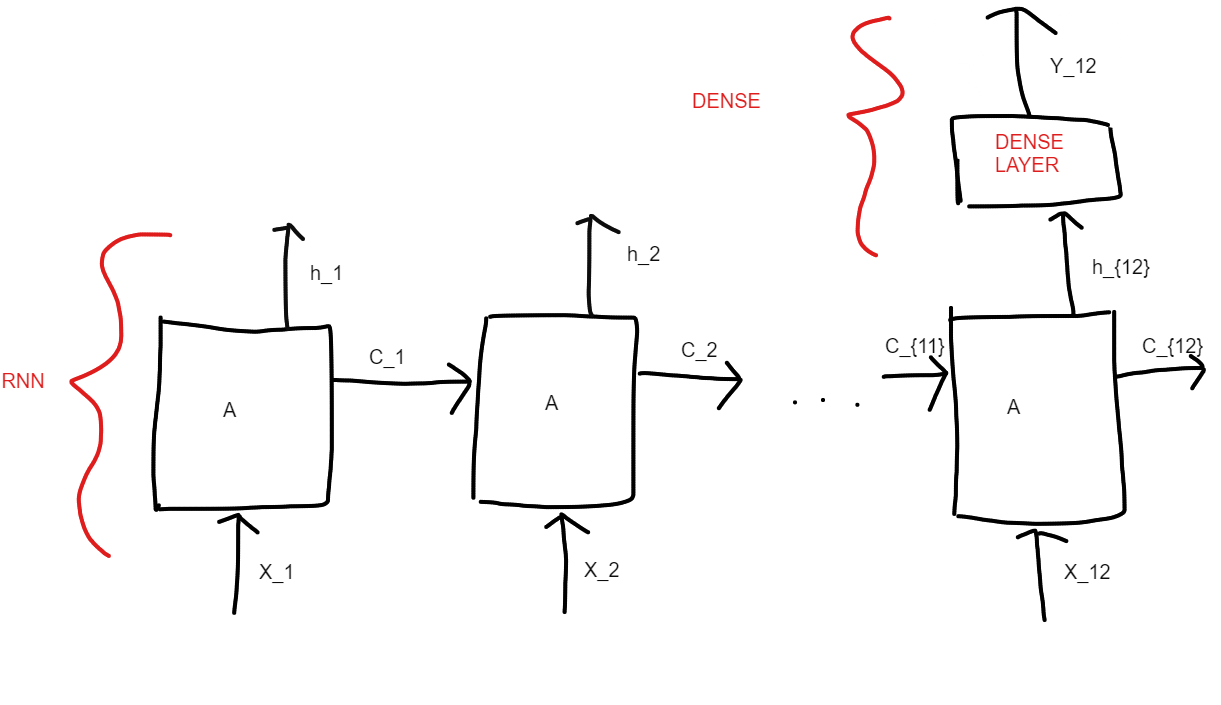

Input sample, which is a sequence $X_1, ..., X_{12}$, representing $12$ consecutive months. The final output is $Y_{12}$, which is the prediction for the next month.

In [ ]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense 
from tensorflow.keras import Model

In [ ]:
x = Input(shape=(12,1))

last_h = SimpleRNN(units=3)(x)

y = Dense(units=1)(last_h)

rnn = Model(inputs=x, outputs=y)

In [ ]:
rnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 3)                 15        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


- Input instance $x$: dimensions $12x1$ (sequence of $12$ values).
- The RNN layer takes in input $x$. It returns an output $h_{12}$, with dimensions $3$. Single output (no sequence). Only the last output.
- We given $h_{12}$ in input to a Dense layer, which returns $y$, which is a single value.

## PROCESSING THE DATASET
We are not yet able to give our dataset in input to our model. Because it has not the proper structure.


### Inputs `x_train`, `x_test`
Currently, our dataset is a single sequence of $2820$ values. We want to split that into instances $x$, in which each distance is a sequence of $12$ values. We want to split our single sequence of $2820$ values into all the possible sub-sequences of $12$ adjacent values: these are all the possible instances $x$.

In [ ]:
# Number of train samples x, where each sample x is a sequence of 12 contiguous values
n_train_instances = len(train_data)//12 - 1 
print('Number of train samples:', n_train_instances)

# Number of test samples x, where each sample x is a sequence of 12 contiguous values
n_test_instances = len(test_data)//12 - 1
print('Number of test samples:', n_test_instances) 

Number of train samples: 187
Number of test samples: 46


In [ ]:
# Creating the training set
x_train = train_data[range(12*n_train_instances)]
x_train = np.reshape(x_train, (n_train_instances, 12, 1))    

In [ ]:
# Creating the test set
x_test = test_data[range(12*n_test_instances)]
x_test = np.reshape(x_test, (n_test_instances, 12, 1))    

Now, the `x_test` contains $187$ samples $x$, where each sample $x$ is a sequence of $12$ values $X_1, ..., X_{12}$, corresponding to $12$ contiguous months.

In [ ]:
x_train[0]

array([[0.22852638],
       [0.24665089],
       [0.2758077 ],
       [0.21946414],
       [0.33490935],
       [0.3289992 ],
       [0.37352246],
       [0.2612293 ],
       [0.29905435],
       [0.29747832],
       [0.6249015 ],
       [0.33569738]], dtype=float32)

The same for the test set (but less samples).

### Targets `y_train`, `y_test`

We don't have yet created the targets. For each instance $x$ (i.e. sequence of $12$ values/months), we have a corresponding target $y$, which is the value of the next month. So, for each input sample $x$, the ground truth is a single value $y$.

In [ ]:
# These are the indeces of the values of the targets y
np.arange(12, len(train_data), 12)

array([  12,   24,   36,   48,   60,   72,   84,   96,  108,  120,  132,
        144,  156,  168,  180,  192,  204,  216,  228,  240,  252,  264,
        276,  288,  300,  312,  324,  336,  348,  360,  372,  384,  396,
        408,  420,  432,  444,  456,  468,  480,  492,  504,  516,  528,
        540,  552,  564,  576,  588,  600,  612,  624,  636,  648,  660,
        672,  684,  696,  708,  720,  732,  744,  756,  768,  780,  792,
        804,  816,  828,  840,  852,  864,  876,  888,  900,  912,  924,
        936,  948,  960,  972,  984,  996, 1008, 1020, 1032, 1044, 1056,
       1068, 1080, 1092, 1104, 1116, 1128, 1140, 1152, 1164, 1176, 1188,
       1200, 1212, 1224, 1236, 1248, 1260, 1272, 1284, 1296, 1308, 1320,
       1332, 1344, 1356, 1368, 1380, 1392, 1404, 1416, 1428, 1440, 1452,
       1464, 1476, 1488, 1500, 1512, 1524, 1536, 1548, 1560, 1572, 1584,
       1596, 1608, 1620, 1632, 1644, 1656, 1668, 1680, 1692, 1704, 1716,
       1728, 1740, 1752, 1764, 1776, 1788, 1800, 18

In [ ]:
# Targets y, for the training set
y_train = train_data[np.arange(12, len(train_data), 12)]

In [ ]:
y_train.shape

(187,)

`y_train`: $187$ values.

In [ ]:
# We do the same for the test set
y_test = test_data[np.arange(12, len(test_data), 12)]

## TRAINING THE NETWORK
Let's finally train the network.

### Compiling

We use MSE as loss function. For each sample $x$, the associated error is the MSE between the real value $y$ of the next month and the prediction $\hat{y}$ of the value of the next month.

In [ ]:
rnn.compile(loss='mean_squared_error', optimizer='adam')

### Training

In [ ]:
rnn.fit(x_train, y_train, epochs=20, batch_size=1)

Epoch 1/20
187/187 [==============================] - 4s 7ms/step - loss: 0.0212
Epoch 2/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0133
Epoch 3/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0102
Epoch 4/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0085
Epoch 5/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0074
Epoch 6/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0066
Epoch 7/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0061
Epoch 8/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0057
Epoch 9/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0054
Epoch 10/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0050
Epoch 11/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0049
Epoch 12/20
187/187 [==============================] - 1s 7ms/step - loss: 0.0047
Epoch 13/20
187/187 [====

## ANALYSIS OF THE RESULS
We apply our network on the training and test set, for making the prediction for each month in the dataset.

In [ ]:
y_train_predict = rnn.predict(x_train)
y_test_predict = rnn.predict(x_test)

### Computing the errors

In [ ]:
import math
from sklearn.metrics import mean_squared_error
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse)) 

In [ ]:
print_error(y_train, y_test, y_train_predict, y_test_predict)

Train RMSE: 0.061 RMSE
Test RMSE: 0.075 RMSE


Quite good results!

### Visualizing the results

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

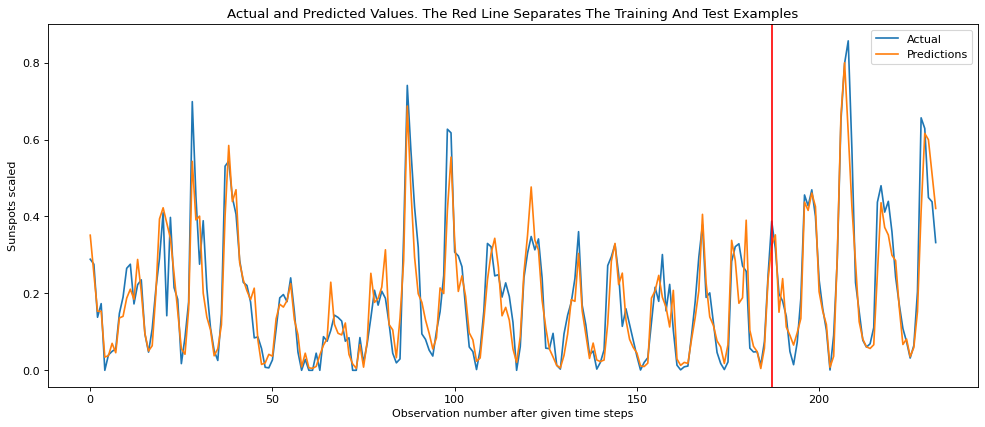

In [ ]:
plot_result(y_train, y_test, y_train_predict, y_test_predict)

Quite good results!